#Imports

In [1]:
# File saved on google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import requests
import sys
import json
from datetime import datetime, timedelta
import holidays

np.random.seed(42)
import scipy
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

#Data Modelling

####Import Cleaned CSV

In [3]:
data_path = "/content/drive/MyDrive/Project/data/final_trip_feature_data.csv"
df_full_non_zero_net_demand_trim = pd.read_csv(data_path)

In [4]:
df_full_non_zero_net_demand_trim = df_full_non_zero_net_demand_trim.rename(columns={
    "Start Station Id" : "Station Id",
    "Binned_Start_Time" : "Time",
    "capacity" : "Station Capacity",
    "nearest_transit" : "Nearest Transit Station Name",
    "POI_distance" : "Distance to Nearest Transit Station",
    "Is_Weekend" : "Weekend",
    "Active_TO" : "Active TO",
    "Lockdown_Stay_at_Home" : "Lockdown"
})

In [5]:
df_full_non_zero_net_demand_trim[['Active TO','Lockdown','Holiday','Weekend']] = df_full_non_zero_net_demand_trim[['Active TO','Lockdown','Holiday','Weekend']].astype(pd.SparseDtype("int64",0))

In [6]:
df_full_non_zero_net_demand_trim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1912438 entries, 0 to 1912437
Data columns (total 18 columns):
 #   Column                               Dtype           
---  ------                               -----           
 0   Station Id                           int64           
 1   Time                                 object          
 2   Station Capacity                     int64           
 3   Nearest Transit Station Name         object          
 4   Distance to Nearest Transit Station  float64         
 5   Temp (°C)                            float64         
 6   Precip. Amount (mm)                  float64         
 7   Wind Spd (km/h)                      float64         
 8   Wind Dir (10s deg)                   float64         
 9   Visibility (km)                      float64         
 10  Holiday                              Sparse[int64, 0]
 11  Weekend                              Sparse[int64, 0]
 12  Year                                 int64           
 1

In [7]:
df_full_non_zero_net_demand_trim = df_full_non_zero_net_demand_trim.sample(frac = 0.1, random_state = 42)

In [8]:
df_full_non_zero_net_demand_trim.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191244 entries, 1546401 to 1370624
Data columns (total 18 columns):
 #   Column                               Non-Null Count   Dtype           
---  ------                               --------------   -----           
 0   Station Id                           191244 non-null  int64           
 1   Time                                 191244 non-null  object          
 2   Station Capacity                     191244 non-null  int64           
 3   Nearest Transit Station Name         191244 non-null  object          
 4   Distance to Nearest Transit Station  191244 non-null  float64         
 5   Temp (°C)                            191244 non-null  float64         
 6   Precip. Amount (mm)                  191244 non-null  float64         
 7   Wind Spd (km/h)                      191244 non-null  float64         
 8   Wind Dir (10s deg)                   191244 non-null  float64         
 9   Visibility (km)                      1912

### Train Test Split

In [9]:
X = df_full_non_zero_net_demand_trim.drop("Positive Net Demand", axis = 1)
Y = df_full_non_zero_net_demand_trim["Positive Net Demand"].copy()

In [10]:
X_train_pre_pipeline, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 123, stratify = Y)

## Pipeline Creation

In [11]:
# This class is defined in the textbook and simply restricts the dataframe to specific features
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names=attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [12]:
num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(['Station Capacity','Distance to Nearest Transit Station', 'Temp (°C)', 'Precip. Amount (mm)', 'Wind Spd (km/h)',
       'Wind Dir (10s deg)', 'Visibility (km)', 'Month','Holiday', 'Weekend', 'Active TO', 'Lockdown'])),
        ('std_scaler', RobustScaler())
    ])

In [13]:
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(['Time', 'Nearest Transit Station Name'])),
        ("cat_encoder", OneHotEncoder(categories='auto')),
    ])

In [14]:
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [15]:
X_train = preprocess_pipeline.fit_transform(X_train_pre_pipeline)

In [16]:
X_train.shape

(152995, 78)

# PCA

In [ ]:
X_train =X_train.toarray()

In [ ]:
pca = PCA(n_components = 0.95 )
X_reduced = pca.fit_transform(X_train)

In [ ]:
X_reduced.shape

(305990, 28)

#Logistic Regression

In [ ]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_reduced, Y_train)

LogisticRegression(max_iter=1000)

In [ ]:
print("RF - model score: %.3f" % log_reg.score(X_reduced, Y_train))

RF - model score: 0.543


#K Nearest Neighbours

In [17]:
KN_clf = KNeighborsClassifier()

KN_param_grid= [{'n_neighbors':[5,10]}]

In [18]:
KN_grid_search = GridSearchCV(KN_clf, KN_param_grid, cv = 3, scoring = 'roc_auc')
KN_grid_search.fit(X_train, Y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [5, 10]}], scoring='roc_auc')

In [23]:
bmodel = KN_grid_search.best_estimator_

In [25]:
KN_grid_search.best_score_

0.5961893446915026

In [26]:
X_test_tx = preprocess_pipeline.transform(X_test)

In [27]:
y_test_pred = bmodel.predict(X_test_tx)

In [28]:
accuracy_score(Y_test, y_test_pred)

0.5708384532928965

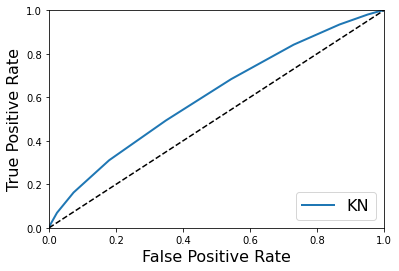

In [29]:
from sklearn.metrics import roc_curve

y_test_score = bmodel.predict_proba(X_test_tx)
fpr_forest, tpr_forest, thresholds_forest = roc_curve(Y_test, y_test_score[:,1])

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0, 1, -0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    
#Plot the Roc Curve
plot_roc_curve(fpr_forest, tpr_forest, "KN")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [ ]:
# #%%time
# forest_PCA = RandomForestClassifier(n_estimators=100, random_state=0)
# accuracy = forest_PCA.fit(X_reduced,Y_train)